In [41]:
!pip install XGBoost

In [164]:
import numpy as np 
import pandas as pd 
import sklearn as sk 
import matplotlib.pyplot as plt
from typing import Tuple
import glob

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor, XGBClassifier

from scipy.signal import find_peaks, peak_prominences

In [111]:
#moved everything out
from utils import visualize, percent_healthy, get_glucose_response

In [112]:
paths = glob.glob(r"../../CGMacros/CGMacros-*/CGMacros-*.csv", recursive=True)

In [113]:
paths[0]

'../../CGMacros/CGMacros-014/CGMacros-014.csv'

## Analysis for Single Participant 

In [145]:
def discretize(sp):
    disc = []
    for spike in sp:
        
        if spike is None:
            disc.append(None)
        elif spike < 50:
            disc.append(0)
        elif spike < 100:
            disc.append(1)
        else:
            disc.append(2)
    return disc


In [146]:

def get_glucose_response(df: pd.DataFrame, unhealthy = False, discrete = False) -> pd.DataFrame:
    meals = df[df["Calories"] != 0].copy(deep=True) #get matrix of just meals and set index columns
    meals["idx"] = meals.index 
    
    libre = df["Libre GL"]
    dexcom = df["Dexcom GL"]
        
    peaks_lib, _ = find_peaks(libre, prominence = 10)
    _, lbase_lib, _ = peak_prominences(libre, peaks=peaks_lib) #just want indices of left value
    
    peaks_dex, _ = find_peaks(dexcom, prominence = 10)
    _, lbase_dex, _ = peak_prominences(dexcom, peaks=peaks_dex)

    
    spikes_lib = []
    spikes_dex = []
    for i in range(len(meals)): #iterate through all the meals
        
        curr_meal_idx = meals.iloc[i,-1]
        next_meal_idx = meals.iloc[i+1, -1] if i+1 < len(meals)-1 else len(df)
        
        #find first prominence after each meal --> LIBRE CGM
        next_peaks_lib = np.ravel(np.where((peaks_lib > curr_meal_idx) & (peaks_lib < next_meal_idx))) #idx #get all peak idxs greater than the location of this meal
        #get first spike and add
        if len(next_peaks_lib) > 0:
            if unhealthy: #just get the postmeal spikes that are in red range
                poss = [idx for idx in next_peaks_lib if libre[peaks_lib[idx]] > RED]
                if len(poss) == 0:
                    spikes_lib.append(None)
                else:
                    next_peak_idx = poss[0]
                    prom = libre[peaks_lib[next_peak_idx]] - libre[lbase_lib[next_peak_idx]] #get just left height
                    spikes_lib.append(prom)
            else:
                next_peak_idx = next_peaks_lib[0] #get next idx
                prom = libre[peaks_lib[next_peak_idx]] - libre[lbase_lib[next_peak_idx]] #get just left height
                spikes_lib.append(prom)
        else: #no next peak
            spikes_lib.append(None)
        
        #find first prominence after each meal --> DEXCOM CGM
        
        next_peaks_dex = np.ravel(np.where((peaks_dex > curr_meal_idx) & (peaks_dex < next_meal_idx)))
        if len(next_peaks_dex) > 0:
            if unhealthy: #just get the postmeal spikes that are in red range
                poss = [idx for idx in next_peaks_dex if dexcom[peaks_dex[idx]] > RED]
                if len(poss) == 0:
                    spikes_dex.append(None)
                else:
                    next_peak_idx = poss[0]
                    prom = dexcom[peaks_dex[next_peak_idx]] - dexcom[lbase_dex[next_peak_idx]]
                    spikes_dex.append(prom)
            else:
                next_peak_idx = next_peaks_dex[0]
                prom = dexcom[peaks_dex[next_peak_idx]] - dexcom[lbase_dex[next_peak_idx]]
                spikes_dex.append(prom)
        else: #no next peak
            spikes_dex.append(None)
    
    #checks

    if discrete:
        spikes_lib = discretize(spikes_lib)
        spikes_dex = discretize(spikes_dex)
        
    #print("lib", spikes_lib)
    #print("dex", spikes_dex)
    
    
    meals["lib_prom"] = spikes_lib #make new columns
    meals["dex_prom"] = spikes_dex #make new columns
    
    meals = meals.dropna(subset=["lib_prom", "dex_prom"]) #remove meals who don't have a corresponding spike
    
    return meals

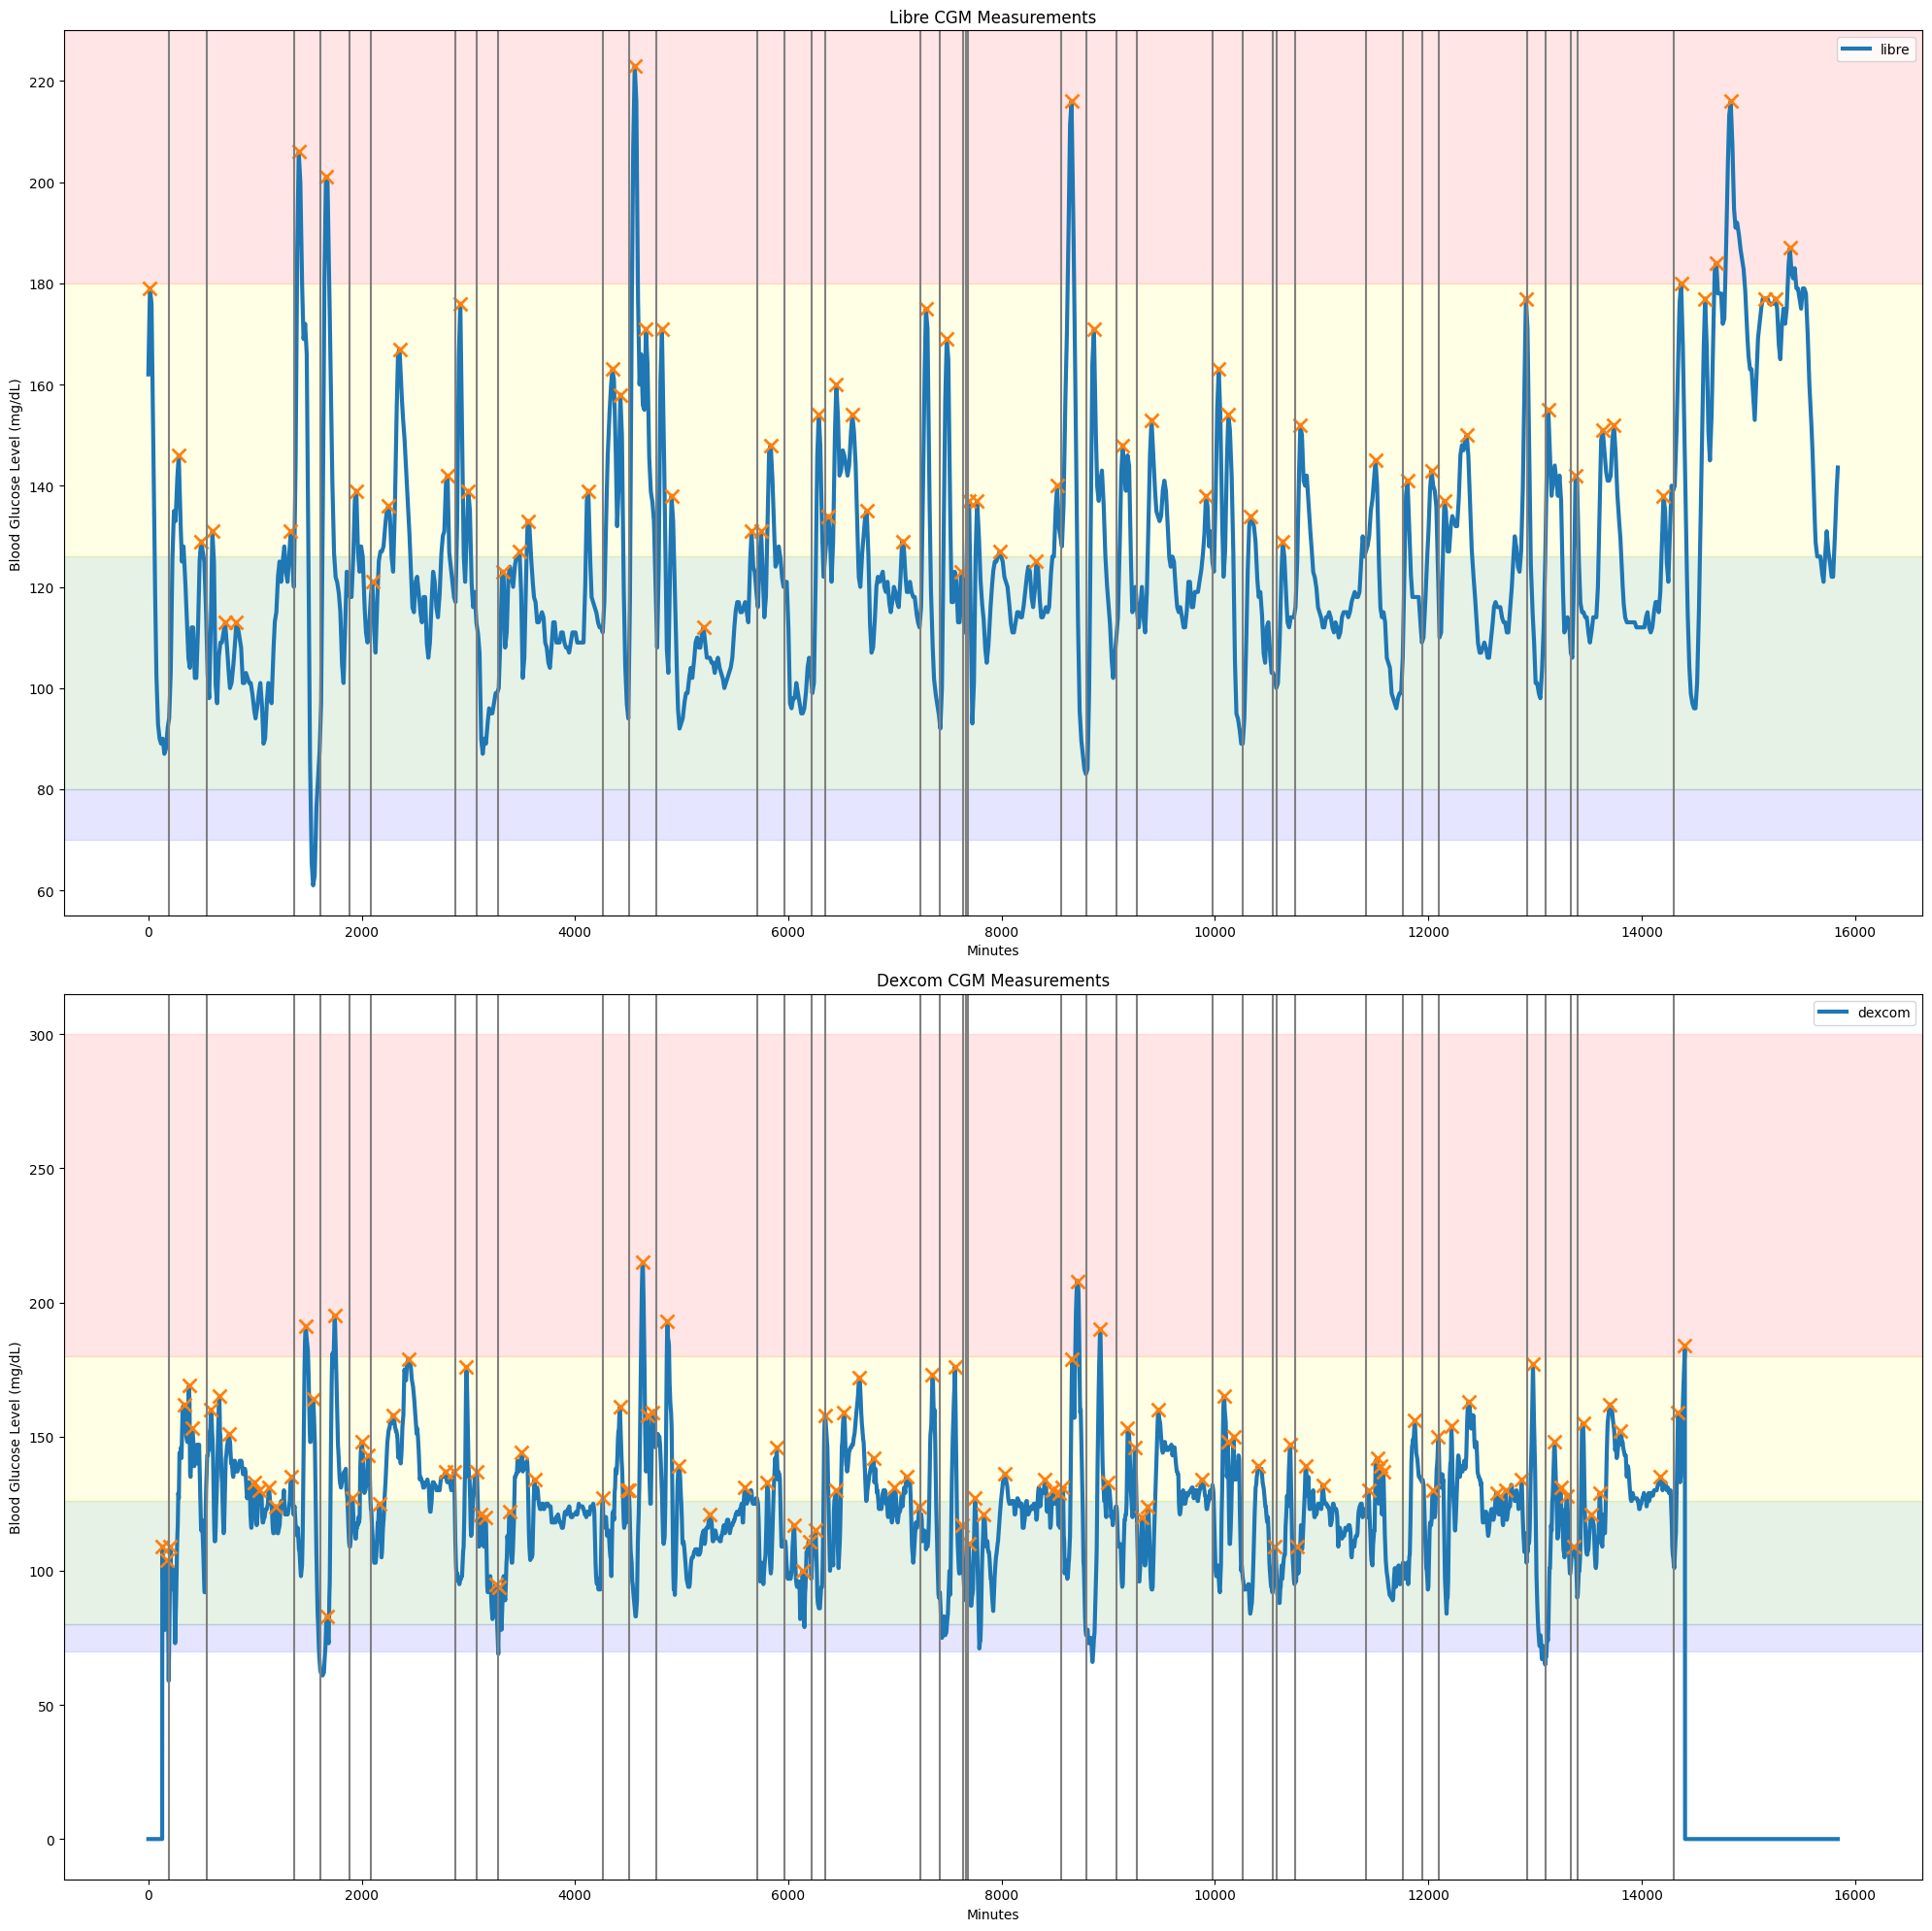

phlib 0.6037247474747475, phdex 0.48409090909090907


In [147]:
df = pd.read_csv(paths[1]).fillna(0)
visualize(df)
ph_lib, ph_dex = percent_healthy(df)

print(f"phlib {ph_lib}, phdex {ph_dex}")


In [148]:
4 in mldf["lib_prom"]

False

In [149]:
mldf = get_glucose_response(df, unhealthy=False, discrete=True)
mldf

,Timestamp,Libre GL,Dexcom GL,HR,Calories (Activity),METs,Meal Type,Calories,Carbs,Protein,Fat,Fiber,Sugar,Amount Consumed,Image path,idx,lib_prom,dex_prom
190,2024-01-25 11:52:00,93.333333,63.8,84.0,1.03224,11.0,Lunch,1180.0,81.0,88.0,54.5,18.0,0.0,100.0,photos/00000005-PHOTO-2024-1-25-11-52-0.jpg,190,1.0,2.0
549,2024-01-25 17:51:00,108.200000,139.8,94.0,1.21992,13.0,dinner,558.0,33.0,48.0,22.0,5.0,12.0,100.0,photos/00000007-PHOTO-2024-1-25-17-51-0.jpg,549,0.0,1.0
1366,2024-01-26 07:28:00,121.466667,123.0,95.0,1.21992,13.0,Breakfast,448.0,66.0,22.0,10.5,0.0,0.0,100.0,photos/00000009-PHOTO-2024-1-26-7-28-0.jpg,1366,2.0,2.0
1615,2024-01-26 11:37:00,93.666667,62.2,79.0,2.43984,26.0,Lunch,830.0,92.0,17.0,42.0,10.0,0.0,100.0,photos/00000013-PHOTO-2024-1-26-11-37-0.jpg,1615,2.0,0.0
1882,2024-01-26 16:04:00,120.133333,110.6,95.0,1.12608,12.0,dinner,763.0,78.0,61.0,24.0,12.0,11.0,100.0,photos/00000015-PHOTO-2024-1-26-16-4-0.jpg,1882,0.0,0.0
2089,2024-01-26 19:31:00,118.800000,122.4,94.0,1.21992,13.0,snack,386.0,27.0,13.0,6.0,0.0,12.0,100.0,photos/00000018-PHOTO-2024-1-26-19-31-0.jpg,2089,0.0,0.0
2880,2024-01-27 08:42:00,117.000000,107.8,92.0,1.21992,13.0,Breakfast,608.0,66.0,66.0,10.5,0.0,0.0,100.0,photos/00000020-PHOTO-2024-1-27-8-42-0.jpg,2880,1.0,1.0
3277,2024-01-27 15:19:00,99.466667,74.6,96.0,1.21992,13.0,dinner,826.0,54.0,40.0,50.0,4.0,6.0,100.0,photos/00000029-PHOTO-2024-1-27-15-19-0.jpg,3277,0.0,0.0
4261,2024-01-28 07:43:00,111.400000,127.0,80.0,1.03224,11.0,Breakfast,712.0,66.0,22.0,42.0,0.0,0.0,100.0,photos/00000031-PHOTO-2024-1-28-7-43-0.jpg,4261,1.0,1.0
4503,2024-01-28 11:45:00,98.600000,130.0,99.0,1.21992,13.0,Lunch,555.0,94.0,12.0,13.0,5.0,0.0,100.0,photos/00000035-PHOTO-2024-1-28-11-45-0.jpg,4503,2.0,2.0


In [150]:
X = mldf[['Calories', 'Carbs', 'Protein', 'Fat', 'Fiber']]
#X = mldf[['Calories', 'Carbs', 'Protein', 'Fat']]


y = mldf['dex_prom']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Create and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)

# Metrics
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)
print("Mean squared error (MSE):", mean_squared_error(y_test, y_pred))
print("R^2 score:", r2_score(y_test, y_pred))

#plt.scatter(mldf["Fiber"], mldf["lib_prom"])


Coefficients: [ 0.0036001  -0.01341218 -0.00798471 -0.03290755  0.01211221]
Intercept: 0.34680748643226783
Mean squared error (MSE): 0.6785240200145871
R^2 score: -0.27875680695056815


## Regression Analysis for All Participants

In [151]:
#get glucose response for all participants
mldf = get_glucose_response(df, unhealthy=False, discrete=True) #unhealthy false, discrete flase
for path in paths:
    df = pd.read_csv(path).fillna(0)
    ml = get_glucose_response(df, unhealthy=False, discrete=True)
    
    mldf = pd.concat([mldf, ml], axis = 0)



In [152]:
mldf

,Timestamp,Libre GL,Dexcom GL,HR,Calories (Activity),METs,Meal Type,Calories,Carbs,Protein,...,Amount Consumed,Image path,idx,lib_prom,dex_prom,Unnamed: 0,Intensity,Amount Consumed,Steps,RecordIndex
190,2024-01-25 11:52:00,93.333333,63.8,84.0,1.03224,11.0,Lunch,1180.0,81.0,88.0,...,100.0,photos/00000005-PHOTO-2024-1-25-11-52-0.jpg,190,1.0,2.0,NaN,NaN,NaN,NaN,NaN
549,2024-01-25 17:51:00,108.200000,139.8,94.0,1.21992,13.0,dinner,558.0,33.0,48.0,...,100.0,photos/00000007-PHOTO-2024-1-25-17-51-0.jpg,549,0.0,1.0,NaN,NaN,NaN,NaN,NaN
1366,2024-01-26 07:28:00,121.466667,123.0,95.0,1.21992,13.0,Breakfast,448.0,66.0,22.0,...,100.0,photos/00000009-PHOTO-2024-1-26-7-28-0.jpg,1366,2.0,2.0,NaN,NaN,NaN,NaN,NaN
1615,2024-01-26 11:37:00,93.666667,62.2,79.0,2.43984,26.0,Lunch,830.0,92.0,17.0,...,100.0,photos/00000013-PHOTO-2024-1-26-11-37-0.jpg,1615,2.0,0.0,NaN,NaN,NaN,NaN,NaN
1882,2024-01-26 16:04:00,120.133333,110.6,95.0,1.12608,12.0,dinner,763.0,78.0,61.0,...,100.0,photos/00000015-PHOTO-2024-1-26-16-4-0.jpg,1882,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9564,2022-01-08 12:18:00,75.400000,130.0,99.0,1.44417,NaN,lunch,585.0,40.0,76.0,...,100.0,photos/00000032-PHOTO-2022-1-8-12-18-0.jpg,9564,1.0,2.0,NaN,0.0,NaN,NaN,NaN
10598,2022-01-09 05:32:00,51.266667,102.4,0.0,1.11090,NaN,breakfast,712.0,66.0,22.0,...,100.0,photos/00000035-PHOTO-2022-1-9-5-32-0.jpg,10598,1.0,2.0,NaN,0.0,NaN,NaN,NaN
11036,2022-01-09 12:50:00,59.200000,121.0,83.0,1.11090,NaN,lunch,445.0,43.0,20.0,...,100.0,photos/00000037-PHOTO-2022-1-9-12-50-0.jpg,11036,0.0,1.0,NaN,0.0,NaN,NaN,NaN
12016,2022-01-10 05:10:00,40.000000,94.0,0.0,1.11090,NaN,breakfast,268.0,24.0,22.0,...,100.0,photos/00000038-PHOTO-2022-1-10-5-10-0.jpg,12016,1.0,0.0,NaN,0.0,NaN,NaN,NaN


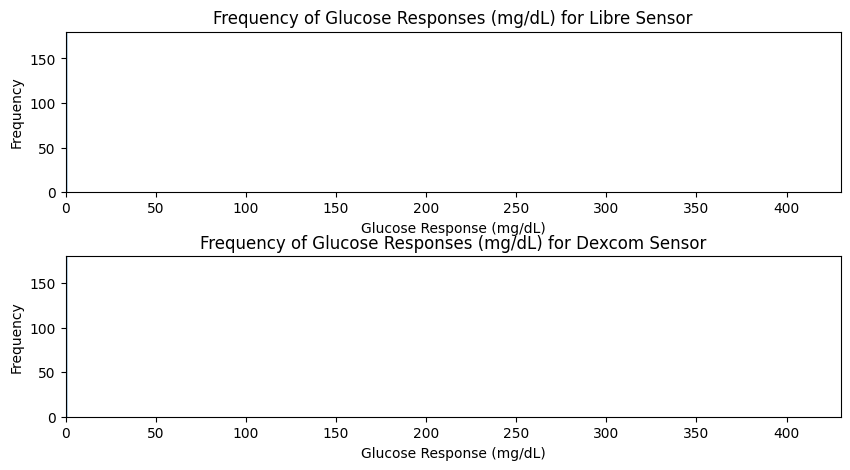

In [153]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (10, 5))
ax[0].hist(mldf["lib_prom"], bins = 30 , alpha = 0.3)
ax[0].set_xlabel("Glucose Response (mg/dL)")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Frequency of Glucose Responses (mg/dL) for Libre Sensor")
ax[0].set_ylim(0, 180)
ax[0].set_xlim(0, 430)

ax[1].hist(mldf["dex_prom"], bins = 30 , alpha = 0.3)
ax[1].set_xlabel("Glucose Response (mg/dL)")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Frequency of Glucose Responses (mg/dL) for Dexcom Sensor")
ax[1].set_ylim(0, 180)
ax[1].set_xlim(0, 430)


plt.subplots_adjust(
   
    wspace=0.3, # width space between columns
    hspace=0.4  # height space between rows
)


In [154]:
print(np.max(mldf["Calories"]))
print(np.max(mldf["Carbs"]))
print(np.max(mldf["Protein"]))
print(np.max(mldf["Fat"]))
print(np.max(mldf["Fiber"]))



2826.0
761.0
148.0
508.0
2830.0


In [155]:
mldf = mldf[
    (mldf["Calories"] <= 2100) &
    (mldf["Carbs"] <= 400) &
    (mldf["Protein"] <= 200) &
    (mldf["Fat"] <= 130) &
    (mldf["Fiber"] <= 120) &
    (mldf["lib_prom"] > 0)  # Optional: only meals with a measurable spike
]

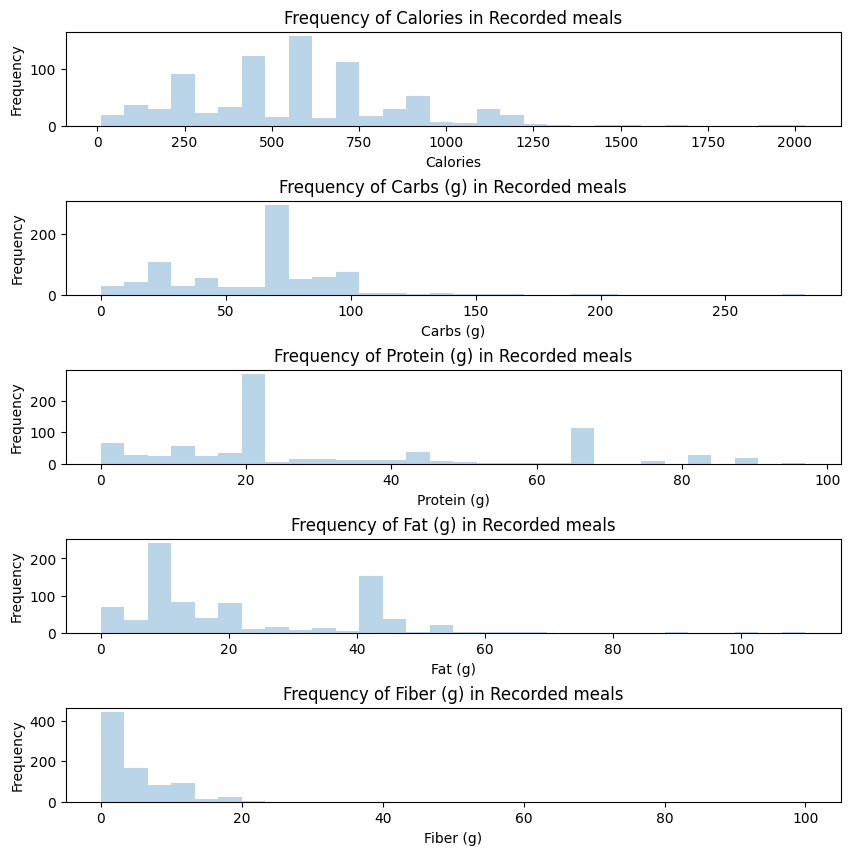

In [156]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize = (10, 10))
ax[0].hist(mldf["Calories"], bins = 30 , alpha = 0.3)
ax[0].set_xlabel("Calories")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Frequency of Calories in Recorded meals")
#ax[0].set_ylim(0, 180)
#ax[0].set_xlim(0, 430)

ax[1].hist(mldf["Carbs"], bins = 30 , alpha = 0.3)
ax[1].set_xlabel("Carbs (g)")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Frequency of Carbs (g) in Recorded meals")
#ax[1].set_ylim(0, 180)
#ax[1].set_xlim(0, 430)

ax[2].hist(mldf["Protein"], bins = 30, alpha = 0.3)
ax[2].set_xlabel("Protein (g)")
ax[2].set_ylabel("Frequency")
ax[2].set_title("Frequency of Protein (g) in Recorded meals")


ax[3].hist(mldf["Fat"], bins = 30, alpha = 0.3)
ax[3].set_xlabel("Fat (g)")
ax[3].set_ylabel("Frequency")
ax[3].set_title("Frequency of Fat (g) in Recorded meals")

ax[4].hist(mldf["Fiber"], bins = 30, alpha = 0.3)
ax[4].set_xlabel("Fiber (g)")
ax[4].set_ylabel("Frequency")
ax[4].set_title("Frequency of Fiber (g) in Recorded meals")

plt.subplots_adjust(
   
    wspace=0.3, # width space between columns
    hspace=0.8  # height space between rows
)

In [157]:
X = mldf[['Calories', 'Carbs', 'Protein', 'Fat',
       'Fiber']]
y = mldf['dex_prom']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Create and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)
       
# Predict
y_pred = lr.predict(X_test)

# Metrics
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)
print("Mean squared error (MSE):", mean_squared_error(y_test, y_pred))
print("R^2 score:", r2_score(y_test, y_pred))

Coefficients: [ 0.00018505  0.00142657 -0.0012396  -0.00249097 -0.00219432]
Intercept: 1.282249929848681
Mean squared error (MSE): 0.5084794486392975
R^2 score: -0.013943004937911008


In [158]:
XGR = XGBRegressor(objective='reg:squarederror', n_estimators = 100, learning_rate = 0.1, max_depth = 5)
XGR.fit(X_train, y_train)

#predict
ypred = XGR.predict(X_test)
print("r2 score:", r2_score(y_test, y_pred))


r2 score: -0.013943004937911008


In [165]:
model = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    num_class=3,
    use_label_encoder=False,
    max_depth = 7,
    n_estimators =300
)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, ypred)
print(cm)
print(f"Accuracy: {acc:.2f}")

/Users/viggy/mambaforge/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:35:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

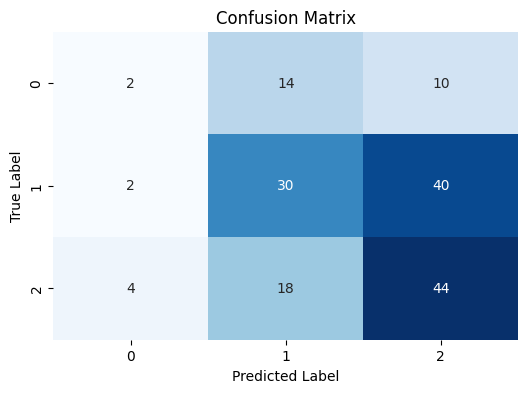

In [163]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # adjust size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Text(0, 0.5, 'PC 2')

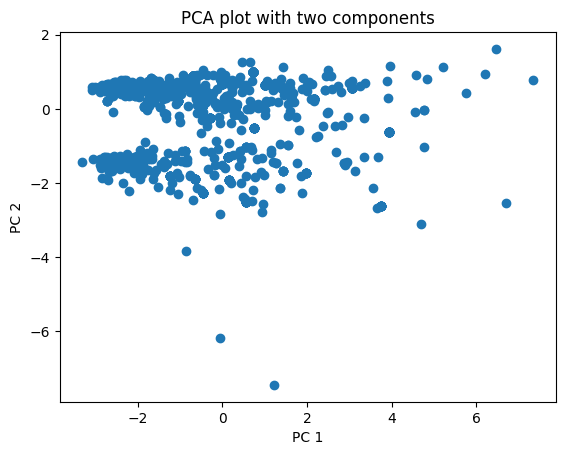

In [87]:
from sklearn.preprocessing import StandardScaler
X_all = mldf[['Calories', 'Carbs', 'Protein', 'Fat',
       'Fiber', "lib_prom"]]
X_np = X_all.to_numpy()
ss = StandardScaler()
X_sc = ss.fit_transform(X_all)

pca = PCA(n_components=2)
X_dimred = pca.fit_transform(X_sc)

plt.scatter(X_dimred[:, 0], X_dimred[:, 1])
plt.title("PCA plot with two components")
plt.xlabel("PC 1")
plt.ylabel("PC 2")

## Testing

In [43]:
mldf["Carbs"]

170      81.0
600      46.0
1394     66.0
1663     92.0
1959     40.0
         ... 
9564     40.0
10598    66.0
11036    43.0
12016    24.0
12517    94.0
Name: Carbs, Length: 1700, dtype: float64

In [51]:
mldf.columns

Index(['Timestamp', 'Libre GL', 'Dexcom GL', 'HR', 'Calories (Activity)',
       'METs', 'Meal Type', 'Calories', 'Carbs', 'Protein', 'Fat', 'Fiber',
       'Amount Consumed', 'Image path', 'idx', 'lib_prom', 'dex_prom', 'Sugar',
       'Unnamed: 0', 'Intensity', 'Amount Consumed ', 'Steps', 'RecordIndex'],
      dtype='object')

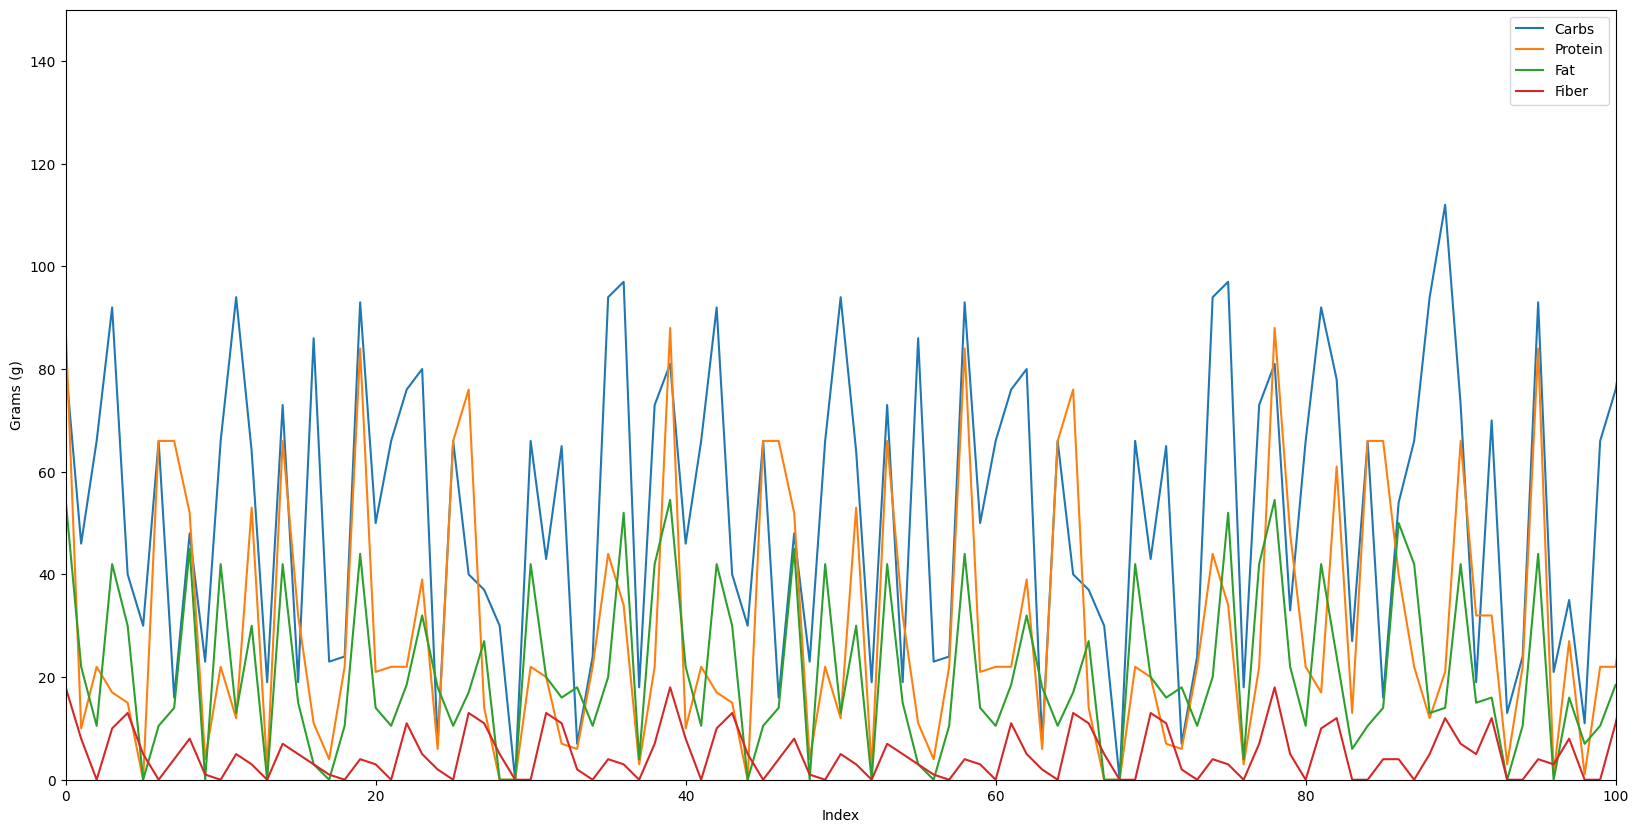

In [54]:
#plotting change in macros over time
plt.figure(figsize=(20,10))
t = np.arange(0,len(mldf["Carbs"]), 1)
plt.plot(t, mldf["Carbs"], label = "Carbs")
plt.plot(t, mldf["Protein"], label = "Protein")
plt.plot(t, mldf["Fat"], label = "Fat")
plt.plot(t, mldf["Fiber"], label = "Fiber")
plt.xlim(0, 100)
plt.ylim(0, 150)
plt.xlabel("Index")
plt.ylabel("Grams (g)")
plt.legend()

(array([490., 330., 522., 278.,  28.,  15.,   5.,   3.,   1.,   1.,   2.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.        ,  25.36666667,  50.73333333,  76.1       ,
        101.46666667, 126.83333333, 152.2       , 177.56666667,
        202.93333333, 228.3       , 253.66666667, 279.03333333,
        304.4       , 329.76666667, 355.13333333, 380.5       ,
        405.86666667, 431.23333333, 456.6       , 481.96666667,
        507.33333333, 532.7       , 558.06666667, 583.43333333,
        608.8       , 634.16666667, 659.53333333, 684.9       ,
        710.26666667, 735.63333333, 761.        ]),
 <BarContainer object of 30 artists>)

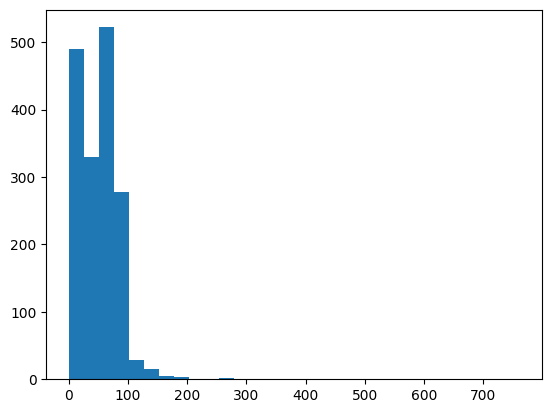

In [21]:
plt.hist(mldf["Carbs"], bins = 30)

In [30]:
mldf_meals65 = mldf[(mldf["Carbs"] < 70) & (mldf["Carbs"] > 60)]
for i in range(len(mldf_meals65)):
    print(mldf_meals65.iloc[i, 6:13])
    print()

Meal Type          breakfast
Calories               448.0
Carbs                   66.0
Protein                 22.0
Fat                     10.5
Fiber                    0.0
Amount Consumed        100.0
Name: 605, dtype: object

Meal Type          breakfast
Calories               608.0
Carbs                   66.0
Protein                 66.0
Fat                     10.5
Fiber                    0.0
Amount Consumed        100.0
Name: 1936, dtype: object

Meal Type          breakfast
Calories               712.0
Carbs                   66.0
Protein                 22.0
Fat                     42.0
Fiber                    0.0
Amount Consumed        100.0
Name: 3419, dtype: object

Meal Type          breakfast
Calories               448.0
Carbs                   66.0
Protein                 22.0
Fat                     10.5
Fiber                    0.0
Amount Consumed        100.0
Name: 7807, dtype: object

Meal Type          breakfast
Calories               608.0
Carbs                  

(0.0, 150.0)

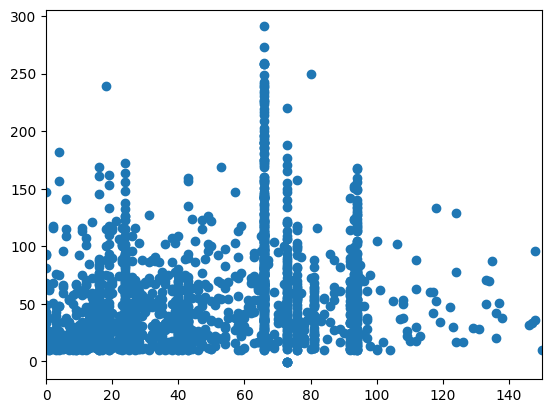

In [158]:
plt.scatter(mldf["Carbs"], mldf["lib_prom"])
plt.xlim(0, 150)

In [ ]:
X = mldf[['Calories', 'Carbs', 'Protein', 'Fat',
       'Fiber']]
y = mldf['lib_prom']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Create and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)

# Metrics
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)
print("Mean squared error (MSE):", mean_squared_error(y_test, y_pred))
print("R^2 score:", r2_score(y_test, y_pred))


Coefficients: [-0.00793351  0.22256291 -0.00624149  0.06363912 -0.0246382 ]
Intercept: 48.961522210093364
Mean squared error (MSE): 1923.5882038348373
R^2 score: 0.007670459891559345
